In [27]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt


In [29]:
# Load the MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
X_train = (X_train * 2.0) - 1.0  # Normalize to [-1, 1]

In [30]:
# Hyperparameters
latent_dim = 100
batch_size = 256
epochs = 100

In [31]:
# Generator Model
def build_generator():
    noise = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256)(noise)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dense(28 * 28 * 1, activation="tanh")(x)
    image = layers.Reshape((28, 28, 1))(x)
    model = models.Model(inputs=noise, outputs=image)
    return model

In [32]:
# Discriminator Model
def build_discriminator():
    image = layers.Input(shape=(28, 28, 1))
    x = layers.Flatten()(image)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    validity = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs=image, outputs=validity)
    return model

In [33]:
# Define the combined GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [34]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
)

In [35]:
# Build and compile the generator
generator = build_generator()

In [36]:
# Define generator optimizer separately
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [38]:
# Training Loop
batch_per_epoch = int(X_train.shape[0] / batch_size)
for epoch in range(epochs):
    for batch in range(batch_per_epoch):
        # Get a batch of real images
        real_images = X_train[batch * batch_size : (batch + 1) * batch_size]
        real_labels = np.ones((batch_size, 1), dtype=np.float32)

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1), dtype=np.float32)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        with tf.GradientTape() as tape:
            generated_images = generator(noise)
            validity = discriminator(generated_images)
            g_loss = tf.keras.losses.binary_crossentropy(
                tf.ones_like(validity), validity
            )
        gradients = tape.gradient(g_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(
            zip(gradients, generator.trainable_variables)
        )

    # Print progress
    print(
        f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss.numpy()}"
    )

    # Save generated images
    if epoch % 10 == 0:
        noise = np.random.normal(0, 1, (10, latent_dim))
        generated_images = generator.predict(noise)
        generated_images = (generated_images + 1) / 2.0  # Denormalize to [0,1]
        fig, axes = plt.subplots(2, 5, figsize=(10, 4))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(generated_images[i, :, :, 0], cmap="gray")
            ax.axis("off")
        plt.savefig(f"generated_epoch_{epoch}.png")
        plt.close()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


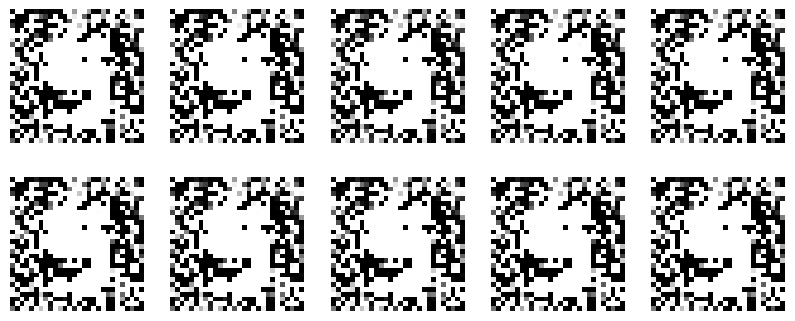

In [39]:
noise = np.random.normal(0, 1, (10, latent_dim))
generated_images = generator.predict(noise)
generated_images = (generated_images + 1) / 2.0  # Denormalize to [0, 1]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i, :, :, 0], cmap="gray")
    ax.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


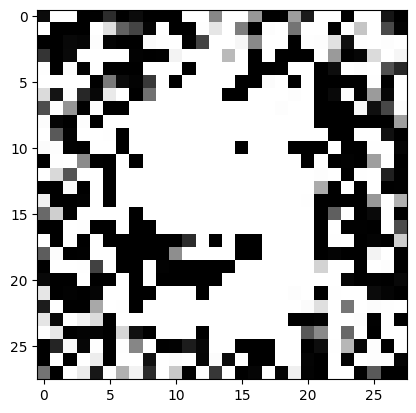

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


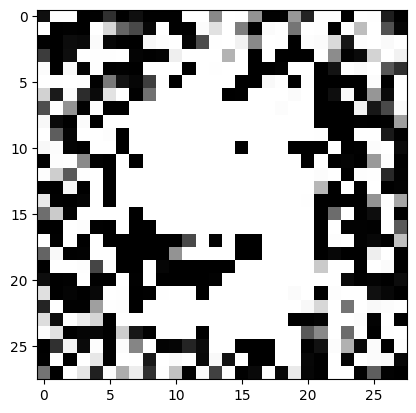

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


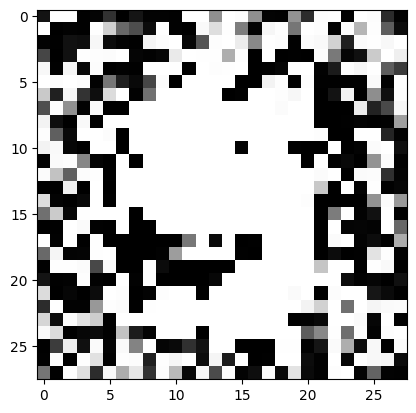

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


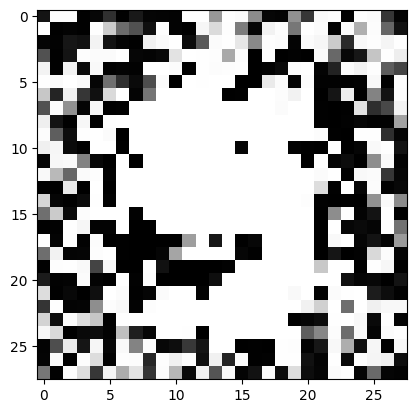

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


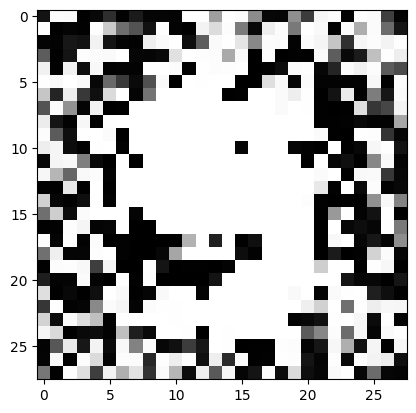

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


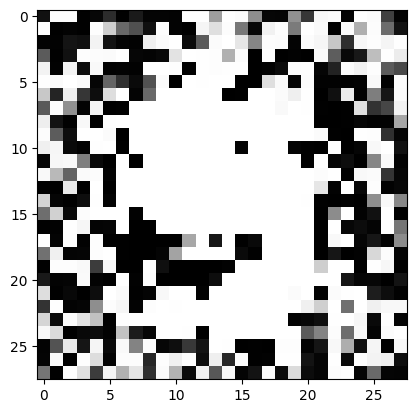

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


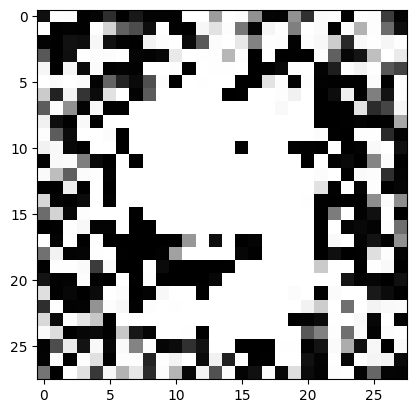

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


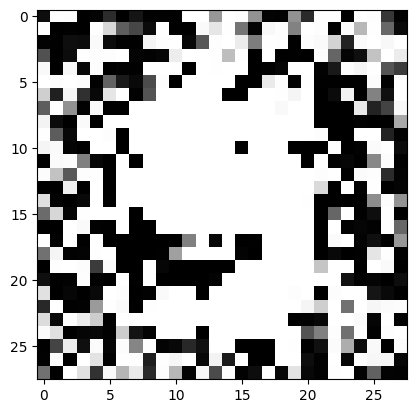

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


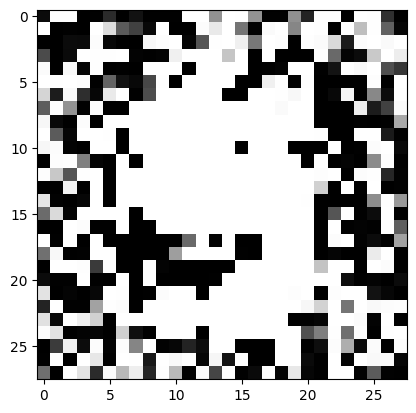

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


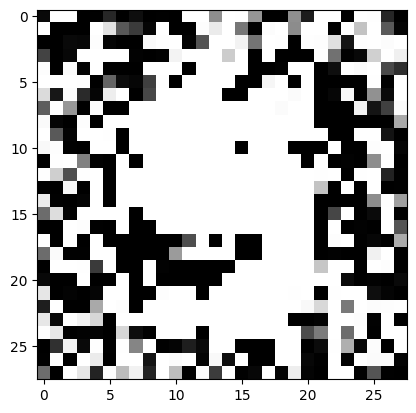

In [41]:
z1 = np.random.normal(0, 1, (1, latent_dim))
z2 = np.random.normal(0, 1, (1, latent_dim))
for alpha in np.linspace(0, 1, 10):
    z = alpha * z1 + (1 - alpha) * z2
    image = generator.predict(z)
    plt.imshow(image[0, :, :, 0], cmap="gray")
    plt.show()

In [42]:
import matplotlib.pyplot as plt

plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'generator_losses' is not defined